In [1]:
import tensorflow as tf
#import wave
import glob
import scipy.io.wavfile as wavfile
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/tmulc/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def getWaveName(wavepath):
    return wavepath.split('/')[-1]

def findWave(wavefile,path):
    r = glob.glob(path+wavefile)
    return r[0]

In [7]:
fpath = '../data/female_us/'
mpath = '../data/male_us/'

In [8]:
#male
result = []
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    result.append(wav_data.shape[0]/(1.0*fm))
resultm = np.array(result)

#female
result = []
for filename in glob.glob(fpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    #fm, wav_data = wave.Wave_read(i)
    result.append(wav_data.shape[0]/(1.0*fm))
resultf = np.array(result)

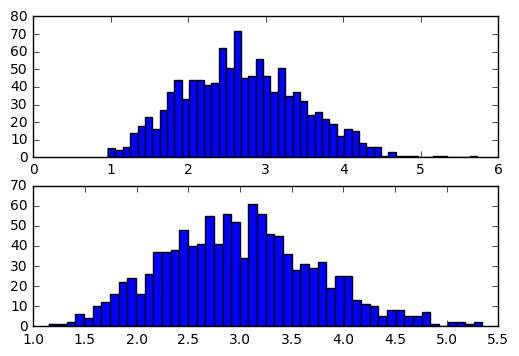

In [13]:
plt.subplot(211)
plt.hist(resultm,bins=50)
plt.subplot(212)
plt.hist(resultf,bins=50)
plt.show()

# Hacky parallel dataset

In [14]:
# map male to female
m2f = dict()
for i in glob.glob(mpath+'/*.wav'):
    m2f[i]=findWave(getWaveName(i),fpath)